In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import nan

In [18]:
data = pd.read_csv('data_owid_16AUGUST.csv')
dates = list(data[data['location'] == 'France']['date'][-502:])
locations = ['Brazil', 'France', 'Germany', 'Israel', 'United Kingdom', 'United States']

In [19]:
end_date = 0
R = 3
a = 0.25
q = 0.4
mu_range = np.logspace(-9,-1)
mu = 1e-7

In [4]:
def calculate_probability_resistance(mu, new_cases, RMT):
    RMT = np.nan_to_num(RMT)
    RMT[RMT<1]=1
    parray = [1-np.prod([(1-mu*(1-1/list(RMT)[t]))**list(new_cases)[t] for t in range(tau)]) for tau in range(len(new_cases))]
    return(parray)

In [15]:
all_results = {}

for loc in locations:
    all_results[loc] = {}
    population_size = np.array(data[data['location'] == loc]['population'])[0]
    
    # new cases
    new_cases = data[data['location'] == loc]['new_cases'][-502:].fillna(0)
    new_cases[new_cases<0] = 0
    
    all_results[loc]['dates'] = dates
    all_results[loc]['new_cases'] = new_cases
    
    # susceptible, recovered, vaccinated 
    cases = np.cumsum(new_cases)
    vaccinations = data[data['location'] == loc]['people_fully_vaccinated'][-502:].fillna(method='ffill')
    susceptible = np.ones(502)*population_size - cases - np.nan_to_num(vaccinations)
    
    all_results[loc]['recovered'] = cases
    all_results[loc]['vaccinated'] = vaccinations
    all_results[loc]['susceptible'] = susceptible
    
    # RWT
    RWT = data[data['location'] == loc]['reproduction_rate'][-502:]
    all_results[loc]['RWT'] = RWT
    
    # RMT q=1
    beta = (R*a)/population_size
    social_distancing = (a*RWT.fillna(1))/(beta*susceptible)
    RMT = (beta*social_distancing*population_size)/a
    all_results[loc]['RMT'] = RMT 
    
    # RMT q = 0.4
    RMT_q = (beta*social_distancing*(susceptible+q*cases+q*vaccinations))/a
    all_results[loc]['RMTq'] = RMT_q
    
    # probability of resistance
    RMT[RMT<1]=1
    RMT_q[RMT_q<1]=1

    P_time = calculate_probability_resistance(mu, new_cases, RMT)
    P_time_q = calculate_probability_resistance(mu, new_cases, RMT_q)
    
    all_results[loc]['Ptime'] = P_time
    all_results[loc]['Ptimeq'] = P_time_q

#### Data for Table 2

In [20]:
beginning_vaccination = -240
beginning_infection = -502

In [27]:
data.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [23]:
populations = dict(zip(locations, [212.6,68.1,83.8,8.7,67.9,331]))

In [28]:
for country in locations:
    print(country)
    vaccinations_per_day = data[data['location'] == country]['new_vaccinations'][beginning_vaccination:]
    print('Vaccinations per day: ', np.mean(vaccinations_per_day)/populations[country])
    new_cases = data[data['location'] == country]['new_cases'][-502:].fillna(0)
    new_cases[new_cases<0] = 0
    print('Infections per day before vaccination: ', np.mean(new_cases[:beginning_vaccination])/populations[country])
    print('Infections per day after vaccination: ', np.mean(new_cases[beginning_vaccination:])/populations[country])
    print('Probability: ', all_results[country]['Ptime'][-1])
    print('\n\n')

Brazil
Vaccinations per day:  3546.089797314633
Infections per day before vaccination:  128.49383855284984
Infections per day after vaccination:  258.7237574474757
Probability:  0.20838334364497246



France
Vaccinations per day:  5142.061081484917
Infections per day before vaccination:  141.3376713633969
Infections per day after vaccination:  267.4415687714146
Probability:  0.12474176684389349



Germany
Vaccinations per day:  5067.158862335984
Infections per day before vaccination:  64.44966204521853
Infections per day after vaccination:  116.664130867144
Probability:  0.042929575783593465



Israel
Vaccinations per day:  5853.074954119579
Infections per day before vaccination:  159.8819864876722
Infections per day after vaccination:  272.6345785440613
Probability:  0.02566415499490915



United Kingdom
Vaccinations per day:  5819.0505188889265
Infections per day before vaccination:  109.27700142778444
Infections per day after vaccination:  265.1862420225822
Probability:  0.156651813

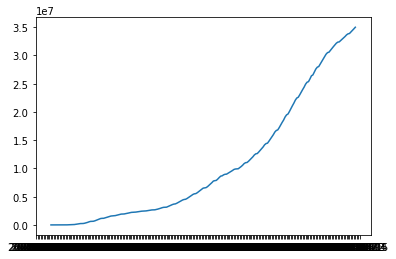

In [12]:
plt.plot(all_results['France']['dates'], data[data['location'] == 'France']['people_fully_vaccinated'][-502:])

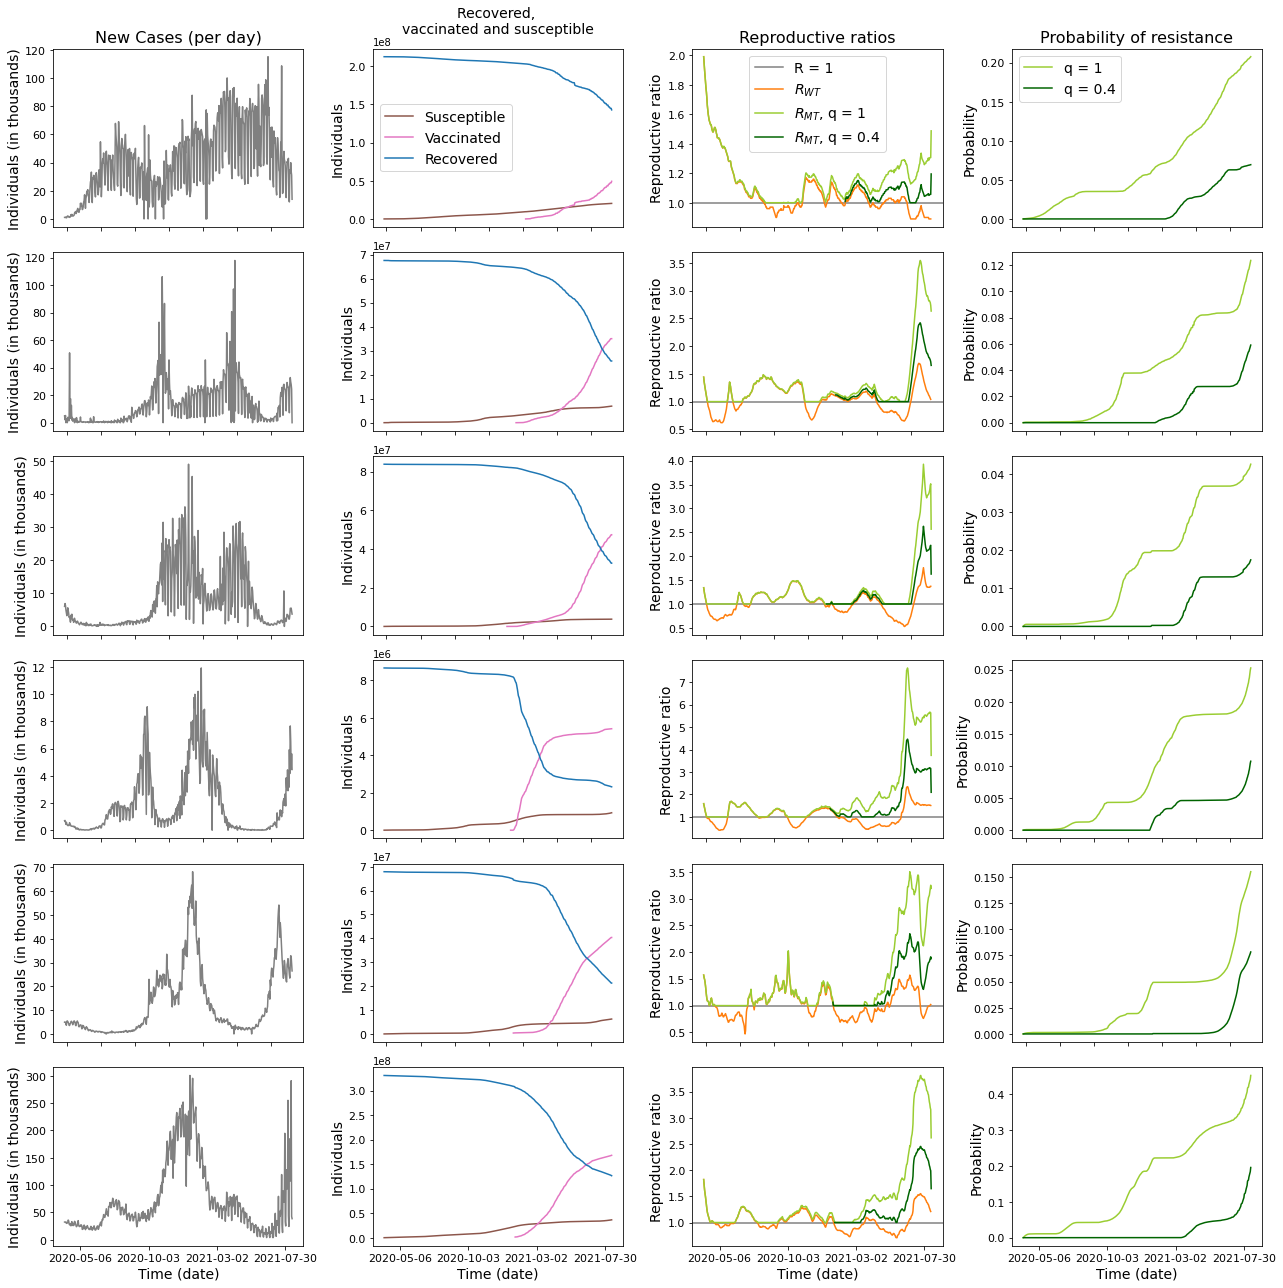

In [16]:
fig, ax = plt.subplots(6,4, figsize = (18,18))


ax[0,0].set_title('New Cases (per day)', fontsize=16)
ax[0,1].set_title('Recovered, \nvaccinated and susceptible', fontsize=14, pad = 15)
ax[0,2].set_title('Reproductive ratios', fontsize = 16)
ax[0,3].set_title('Probability of resistance', fontsize = 16)

for loc in locations:
    index = locations.index(loc)
    
    # New Cases
    ax[index, 0].plot(all_results[loc]['dates'], np.array(all_results[loc]['new_cases']) / 1e3, c = 'grey')
    ax[index,0].set_xticks(np.arange(5,len(dates),75))
    ax[index,0].set_xticklabels(['' for x in np.arange(5,len(dates),75)])
    
    # Susceptible, Recovered, Vaccinated
    ax[index,1].plot(all_results[loc]['dates'][:-1], all_results[loc]['recovered'][:-1], c='C5')
    ax[index,1].plot(all_results[loc]['dates'][:-1], all_results[loc]['vaccinated'][:-1], c='C6')
    ax[index,1].plot(all_results[loc]['dates'][:-1], all_results[loc]['susceptible'][:-1], c='C0')
    ax[index,1].set_xticks(np.arange(5,len(dates),75))
    ax[index,1].set_xticklabels(['' for x in np.arange(5,len(dates),75)])
    
    # RWT, RMT (q=0.4), RMT (q=1)
    ax[index,2].axhline(1, c='grey')
    ax[index,2].plot(all_results[loc]['dates'][:-1], all_results[loc]['RWT'][:-1], c = 'C1')
    ax[index,2].plot(all_results[loc]['dates'][:-1], all_results[loc]['RMT'][:-1], c = 'yellowgreen')
    ax[index,2].plot(all_results[loc]['dates'][:-1], all_results[loc]['RMTq'][:-1], c = 'darkgreen')
    ax[index,2].set_xticks(np.arange(5,len(dates),75))
    ax[index,2].set_xticklabels(['' for x in np.arange(5,len(dates),75)])
    
    for i in range(6):
        ax[index,0].set_ylabel('Individuals (in thousands)', fontsize = 14)
        ax[index,1].set_ylabel('Individuals', fontsize = 14)
        ax[index,2].set_ylabel('Reproductive ratio', fontsize = 14)
        ax[index,3].set_ylabel('Probability', fontsize = 14)
        
        for j in range(4):
            ax[5, j].set_xlabel('Time (date)', fontsize = 14)
            ax[i,j].tick_params(labelsize = 11)
        
    # Probability of Resistance Emergence
    ax[index,3].plot(all_results[loc]['dates'][:-1], all_results[loc]['Ptime'][:-1], c = 'yellowgreen')
    ax[index,3].plot(all_results[loc]['dates'][:-1], all_results[loc]['Ptimeq'][:-1], c = 'darkgreen')
    ax[index,3].set_xticks(np.arange(5,len(dates),75))
    ax[index,3].set_xticklabels(['' for x in np.arange(5,len(dates),75)])

ax[3,1].ticklabel_format(axis="y", style="", scilimits=(0,0))
ax[5,0].set_xticks(np.arange(35,len(dates),150))
ax[5,0].set_xticklabels([dates[x] for x in np.arange(35,len(dates),150)])
ax[5,1].set_xticks(np.arange(35,len(dates),150))
ax[5,1].set_xticklabels([dates[x] for x in np.arange(35,len(dates),150)])
ax[5,2].set_xticks(np.arange(35,len(dates),150))
ax[5,2].set_xticklabels([dates[x] for x in np.arange(35,len(dates),150)])
ax[5,3].set_xticks(np.arange(35,len(dates),150))
ax[5,3].set_xticklabels([dates[x] for x in np.arange(35,len(dates),150)])

ax[0,1].legend(['Susceptible', 'Vaccinated', 'Recovered'], fontsize = 14)
ax[0,2].legend(['R = 1', '$R_{WT}$', '$R_{MT}$, q = 1', '$R_{MT}$, q = 0.4'], fontsize = 14)
ax[0,3].legend(['q = 1', 'q = 0.4'], fontsize = 14)


plt.tight_layout()
plt.savefig('all_countries_24panels_14SEPT.jpg', dpi = 400)